In [1]:
from XRDXRFutils import DataXRD, DatabaseXRD, SpectraXRD, GaussNewton

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import re

# Read phase database

In [2]:
path_phases = '../../dati/Database/'
database = DatabaseXRD().read_cifs(path_phases)
phase_chosen = database['Calcite'][0]

# Create experimental spectrum

In [3]:
min_theta = 16
max_theta = 42
min_intensity = None

# Variables along the channels
theta = np.linspace(16, 42, 1280)
theta_dim = theta[:, np.newaxis]

# Variables along the diffraction lines
mu, I = phase_chosen.get_theta(min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity)
mu_dim = mu[np.newaxis, :]
I_dim = I[np.newaxis, :]
g = np.ones(len(I)) * 0.75
g_dim = g[np.newaxis, :]
gamma = GaussNewton.w(g)
gamma_dim = gamma[np.newaxis, :]
tau = np.full(len(mu), 0.16) # 0.04
tau_dim = tau[np.newaxis, :]
sigma2 = GaussNewton.u(tau)
sigma2_dim = sigma2[np.newaxis, :]

# Components of the synthetic function (they go along both axes)
component_core = np.exp((theta_dim - mu_dim)**2 / (-2 * sigma2_dim))
component_full = I_dim * gamma_dim * component_core

# Synthetic function
f = component_full.sum(axis = 1)

spectrum_sample = SpectraXRD().from_array(f)
spectrum_sample.opt = np.array([-741.96144778, 2803.29875555, 31.09111973])

# Gauss-Newton

In [6]:
fit_sample = GaussNewton(phase_chosen, spectrum_sample, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity)

In [10]:
for idx in range(100):
    #fit_sample.fit_GN_a_s_beta()
    #fit_sample.fit_GN_a_s_gamma()
    #fit_sample.fit_GN_gamma()
    fit_sample.fit_GN_sigma()

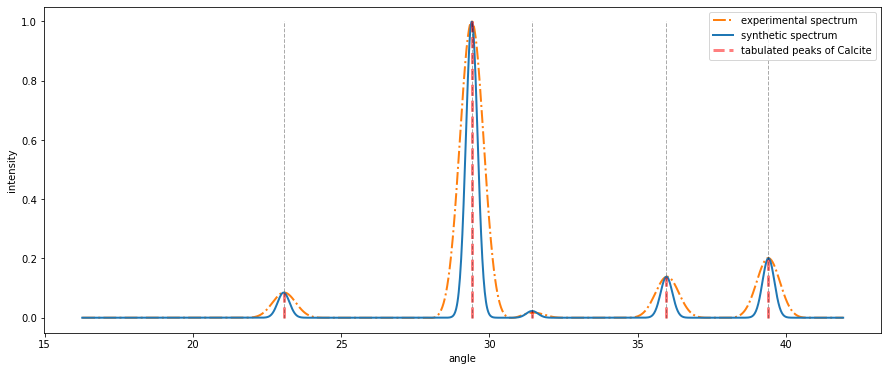

Fit error = 0.08147752281192874
Calibration parameters = [-741.96144778 2803.29875555   31.09111973]
gamma = [1. 1. 1. 1. 1.]
sigma2 = [0.04067737 0.03947422 0.0394104  0.03984778 0.04068529]
Integral of fitted function = 35.48584081968964
Integral of experimental spectrum = 69.3432671516382


In [11]:
fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(fit_sample.theta, fit_sample.intensity, ls = '-.', lw = 2, c = 'tab:orange', label = 'experimental spectrum')
ax.plot(fit_sample.theta, fit_sample.z(), ls = '-', lw = 2, c = 'tab:blue', label = 'synthetic spectrum')
ax.vlines(fit_sample.mu, 0, fit_sample.I, 'r', alpha = 0.5, ls = '--', lw = 3, label = 'tabulated peaks of ' + phase_chosen['_chemical_name_mineral'])
ax.vlines(fit_sample.mu, 0, 1, 'k', alpha = 0.33, ls = '--', lw = 1)
ax.set_xlabel('angle')
ax.set_ylabel('intensity')
ax.legend()
#ax.set_xlim(1200, 1250)
#ax.set_ylim(0, 0.25)
plt.show()

print(f'Fit error = {fit_sample.fit_error()}')
print(f'Calibration parameters = {fit_sample.opt}')
print(f'gamma = {fit_sample.gamma}')
print(f'sigma2 = {fit_sample.sigma2}')
print(f'Integral of fitted function = {np.clip(fit_sample.z(), None, fit_sample.intensity).sum()}')
print(f'Integral of experimental spectrum = {fit_sample.intensity.sum()}')

# Explore functions

In [15]:
f = lambda x: 0.5 * (np.sqrt(x**2 + 1) + x)
f_der = lambda x: 0.5 * (x / np.sqrt(x**2 + 1) + 1)

g = lambda x: f(100 * x) / 100
g_der = lambda x: f_der(100 * x)

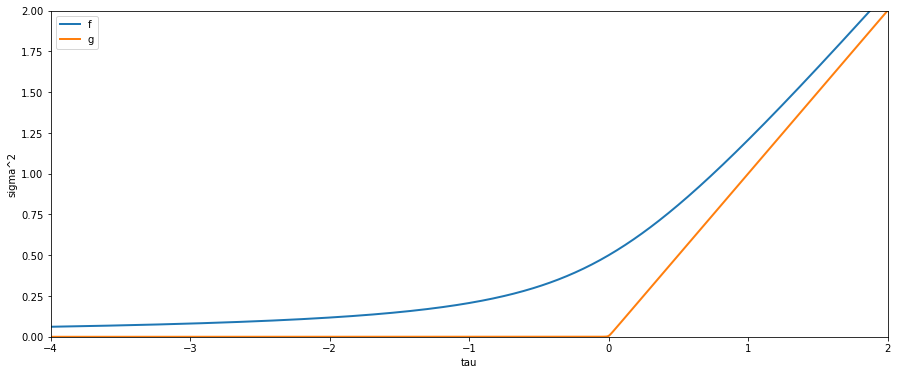

In [19]:
plot_tau = np.arange(-10, 10, 0.01)

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot(plot_tau, f(plot_tau), ls = '-', lw = 2,label = 'f')
ax.plot(plot_tau, g(plot_tau), ls = '-', lw = 2,label = 'g')
ax.set_xlabel('tau')
ax.set_ylabel('sigma^2')
ax.legend()
ax.set_xlim(-4, 2)
ax.set_ylim(0, 2)
plt.show()